In [1]:
%tensorflow_version 2.x
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

TensorFlow 2.x selected.


In [2]:
!git clone https://github.com/fabrizioschembari/Segmentation_Assignment.git

Cloning into 'Segmentation_Assignment'...
remote: Enumerating objects: 16569, done.
remote: Total 16569 (delta 0), reused 0 (delta 0), pack-reused 16569
Receiving objects: 100% (16569/16569), 1.28 GiB | 14.25 MiB/s, done.
Resolving deltas: 100% (7129/7129), done.
Checking out files: 100% (33077/33077), done.


In [3]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

# Set True if it is the first run of the algorithm
first_run = True

# Get current working directory
cwd = os.getcwd()

# Set GPU memory growth
# Allows to only as much GPU memory as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [0]:
def my_IoU(y_true, y_pred):
    # from pobability to predicted class {0, 1}
    y_pred = tf.cast(y_pred > 0.5, tf.float32) # when using sigmoid. Use argmax for softmax

    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union

# Example: Image Segmentation
## Oxford Pet Dataset

### Directory structure

    - Pet_Dataset/
        - training/
            - images/
                - img1, img2, …, imgN
            - masks/ 
                - mask1, mask2, ... , maskN
        - validation/
            - images/
                - img1, img2, …, imgN
            - masks/ 
                - mask1, mask2, ... , maskN
        - test/
            - images/
                - img1, img2, …, imgN
            - masks/ 
                - mask1, mask2, ... , maskN

In [0]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=10,
                                            width_shift_range=10,
                                            height_shift_range=10,
                                            zoom_range=0.3,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='constant',
                                            cval=0,
                                            rescale=1./255)
    train_mask_data_gen = ImageDataGenerator(rotation_range=10,
                                             width_shift_range=10,
                                             height_shift_range=10,
                                             zoom_range=0.3,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             fill_mode='constant',
                                             cval=0,
                                             rescale=1./255)
else:
    train_img_data_gen = ImageDataGenerator(rescale=1./255)
    train_mask_data_gen = ImageDataGenerator(rescale=1./255)

# Create validation and test ImageDataGenerator objects
valid_img_data_gen = ImageDataGenerator(rescale=1./255)
valid_mask_data_gen = ImageDataGenerator(rescale=1./255)
test_img_data_gen = ImageDataGenerator(rescale=1./255)
test_mask_data_gen = ImageDataGenerator(rescale=1./255)

In [0]:
import os
import shutil
import random

def move_files(origin, destination, random_percentage, seed=42):
	random.seed(seed)
	for path, subdirs, files in os.walk(origin):
			for i in subdirs:
					try:
						os.mkdir(destination + '/' + i)
					except FileExistsError:
							pass
			
			dst_path = destination + '/' + path[len(origin):]
			for i in range(int(len(files)*random_percentage)):
					this = random.choice(files)
					shutil.move(path + '/' + this, dst_path + '/' + this)
					files.remove(this)

# move_files('./training', './validation', .1)
# move_files('./training', './testing', .3 * 10 / 9)

def reset_dataset(dataset_dir):
    move_files(origin = dataset_dir + '/validation/images', destination = dataset_dir + '/training/images', random_percentage = 1)
    move_files(origin = dataset_dir + '/validation/masks', destination = dataset_dir + '/training/masks', random_percentage = 1)
    # move_files(origin = dataset_dir + '/testing', destination = dataset_dir + '/training', random_percentage = 1)

def move_files_k_fold(origin, k, seed):
	random.seed(seed)
	for path, subdirs, files in os.walk(origin):
		for j in range(k):
			try:
				os.mkdir(origin + str(j))
			except FileExistsError:
				pass
			for i in subdirs:
				try:
					os.mkdir(origin + str(j) + '/' + i)
				except FileExistsError:
					pass
	    
		n_files = len(files)
		for j in range(k-1):
			dst_path = origin + str(j) + '/' + path[len(origin)+1:]
			for i in range(int(n_files/k)):
				this = random.choice(files)
				shutil.move(path + '/' + this, dst_path + '/' + this)
				files.remove(this)
		dst_path = origin + str(k-1) + '/' + path[len(origin)+1:]
		for f in files:
			shutil.move(path + '/' + f, dst_path + '/' + f)

if not first_run:
	reset_dataset(dataset_dir)
else:
	!mkdir ./Segmentation_Assignment/Segmentation_Dataset/validation
	!mkdir ./Segmentation_Assignment/Segmentation_Dataset/validation/images
	!mkdir ./Segmentation_Assignment/Segmentation_Dataset/validation/masks
	first_run = False

move_files('./Segmentation_Assignment/Segmentation_Dataset/training/images/',
           './Segmentation_Assignment/Segmentation_Dataset/validation/images', 0.2, SEED)
move_files('./Segmentation_Assignment/Segmentation_Dataset/training/masks',
           './Segmentation_Assignment/Segmentation_Dataset/validation/masks', 0.2, SEED)

In [11]:
# Count the number of files in a directory
!ls -l ./Segmentation_Assignment/Segmentation_Dataset/training/images/img | wc -l

6119


In [38]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = os.path.join(cwd, 'Segmentation_Assignment/Segmentation_Dataset')

# Batch size
bs = 64

# img shape
img_h = 256
img_w = 256

#classes are "background" (0) and "building" (1)
num_classes=1

# Training
# Two different generators for images and masks
# ATTENTION: here the seed is important!! We have to give the same SEED to both the generator
# to apply the same transformations/shuffling to images and corresponding masks
training_dir = os.path.join(dataset_dir, 'training')
train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None, # Because we have no class subfolders in this case
                                                       shuffle=True,
                                                       interpolation='bilinear',
                                                       seed=SEED)  
train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs,
                                                         class_mode=None, # Because we have no class subfolders in this case
                                                         shuffle=True,
                                                         interpolation='bilinear',
                                                         seed=SEED)
train_gen = zip(train_img_gen, train_mask_gen)

# Validation
validation_dir = os.path.join(dataset_dir, 'validation')
valid_img_gen = valid_img_data_gen.flow_from_directory(os.path.join(validation_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None, # Because we have no class subfolders in this case
                                                       shuffle=False,
                                                       interpolation='bilinear',
                                                       seed=SEED)
valid_mask_gen = valid_mask_data_gen.flow_from_directory(os.path.join(validation_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs, 
                                                         class_mode=None, # Because we have no class subfolders in this case
                                                         shuffle=False,
                                                         interpolation='bilinear',
                                                         seed=SEED)
valid_gen = zip(valid_img_gen, valid_mask_gen)

# Test
test_dir = os.path.join(dataset_dir, 'test')
test_img_gen = test_img_data_gen.flow_from_directory(os.path.join(test_dir, 'images'),
                                                     target_size=(img_h, img_w),
                                                     batch_size=bs, 
                                                     class_mode=None, # Because we have no class subfolders in this case
                                                     shuffle=False,
                                                     interpolation='bilinear',
                                                     seed=SEED)
#test_mask_gen = test_mask_data_gen.flow_from_directory(os.path.join(test_dir, 'masks'),
 #                                                      target_size=(img_h, img_w),
  #                                                     batch_size=bs, 
   #                                                    class_mode=None, # Because we have no class subfolders in this case
    #                                                   shuffle=False,
     #                                                  interpolation='bilinear',
      #                                                 seed=SEED)
#test_gen = zip(test_img_gen, test_mask_gen)

Found 6118 images belonging to 1 classes.
Found 6118 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1234 images belonging to 1 classes.


In [0]:
# Create Dataset objects
# ----------------------

# Training
# --------
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 3]))

def prepare_target(x_, y_):
    y_ = tf.cast(tf.expand_dims(y_[..., 0], -1), tf.int32)
    return x_, tf.where(y_ > 0, y_ - 1, y_ + 1)

train_dataset = train_dataset.map(prepare_target)

# Repeat
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 3]))
valid_dataset = valid_dataset.map(prepare_target)

# Repeat
valid_dataset = valid_dataset.repeat()

# Test
# ----
test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 3]))
test_dataset = test_dataset.map(prepare_target)

# Repeat
test_dataset = test_dataset.repeat()

In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [41]:
for image, mask in train_gen.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

AttributeError: ignored

In [0]:
np.unique(target_img)


## Convolutional Neural Network (CNN)
### Encoder-Decoder

In [0]:
# Create Model
# ------------

def create_model(depth, start_f, num_classes, dynamic_input_shape):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    for i in range(depth):
        
        if i == 0:
            if dynamic_input_shape:
                input_shape = [None, None, 3]
            else:
                input_shape = [img_h, img_w, 3]
        else:
            input_shape=[None]
        
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         input_shape=input_shape))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        start_f *= 2

    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f // 2,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))

        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='sigmoid'))
    
    return model

In [43]:
model = create_model(depth=4, 
                     start_f=4, 
                     num_classes=num_classes, 
                     dynamic_input_shape=False)

# Visualize created model as a table
model.summary()

# Visualize initialized weights
# model.weights

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 256, 256, 4)       112       
_________________________________________________________________
re_lu_24 (ReLU)              (None, 256, 256, 4)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 4)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 8)       296       
_________________________________________________________________
re_lu_25 (ReLU)              (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 16)       

## Prepare the model for training

In [0]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

#metrics = ['accuracy']
metrics = [my_IoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [46]:
import os
from datetime import datetime

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_my_IoU', patience=1, mode='max')
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen), 
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Train for 96 steps, validate for 24 steps
Epoch 1/100
96/96 [==============================] - 45s 472ms/step - loss: nan - my_IoU: 0.6955 - val_loss: nan - val_my_IoU: 0.6928
Epoch 2/100
41/96 [===========>..................] - ETA: 22s - loss: nan - my_IoU: 0.6969WARNING:tensorflow:Early stopping conditioned on metric `val_my_IoU` which is not available. Available metrics are: loss,my_IoU


KeyboardInterrupt: ignored

## Test model

In [50]:
# Just for exercise try to restore a model after training it
# !! Use this just when restoring model.. 
# ---------------------------------------
restore_model = True
if restore_model:
    model = create_model(depth=4, 
                         start_f=4, 
                         num_classes=num_classes, 
                         dynamic_input_shape=True)

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                  metrics=['accuracy'])  # Needed for loading weights

    model.load_weights(os.path.join(
        cwd, 'segmentation_experiments', 'EXP_FOLDER', 'ckpts', 'cp_60.ckpt'))  # use this if you want to restore saved model
# ----------------------------------------

eval_out = model.evaluate(x=test_dataset,
                          steps=len(test_img_gen),
                          verbose=0)

eval_out

InvalidArgumentError: ignored

## Compute prediction

In [49]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib notebook

# Cycle over test images

test_img_dir = os.path.join(test_dir, 'images', 'img')
test_mask_dir = os.path.join(test_dir, 'masks', 'img')

img_filenames = next(os.walk(test_img_dir))[2]

fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()

# Assign a color to each class
colors_dict = {}
colors_dict[0] = [252, 186, 3]  # foreground
colors_dict[1] = [0, 0, 0]      # background
colors_dict[2] = [3, 82, 252]   # contours

for img_filename in img_filenames:
    
    mask_filename = img_filename[:-4] + '.tif'
    
    img = Image.open(os.path.join(test_img_dir, img_filename))
    img = img.resize((128, 128))
    mask = Image.open(os.path.join(test_mask_dir, mask_filename))
    mask = mask.resize((128, 128))
    
    img_arr = np.expand_dims(np.array(img), 0)
    
    # out_softmax = model.predict(x=img_arr / 255.)
    out_sigmoid = model.predict(x=img_arr)
    
    # Get predicted class as the index corresponding to the maximum value in the vector probability
    # predicted_class = tf.argmax(out_softmax, -1)
    predicted_class = tf.cast(out_sigmoid > 0.5, tf.float32)
    predicted_class = predicted_class[0]
    
    target = np.array(mask)
    target -= 1    ## to get classes 0,1,2 instead of 1,2,3
    
    print(target.shape)
    
    # Assign colors (just for visualization)
    target_img = np.zeros([target.shape[0], target.shape[1], 3])
    prediction_img = np.zeros([target.shape[0], target.shape[1], 3])
    
    target_img[np.where(target == 0)] = colors_dict[0]
    target_img[np.where(target == 1)] = colors_dict[1]
    target_img[np.where(target == 2)] = colors_dict[2]
    
    prediction_img[np.where(predicted_class == 0)] = colors_dict[0]
    prediction_img[np.where(predicted_class == 1)] = colors_dict[1]
    prediction_img[np.where(predicted_class == 2)] = colors_dict[2]
    
    ax[0].imshow(np.uint8(img_arr[0, ...]))
    ax[1].imshow(np.uint8(target_img))
    ax[2].imshow(np.uint8(prediction_img))
    
    fig.canvas.draw()
    time.sleep(1)

<IPython.core.display.Javascript object>

FileNotFoundError: ignored

<IPython.core.display.Javascript object>

In [0]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(csv_fname, 'w') as f:

      f.write('ImageId,EncodedPixels,Width,Height\n')

      for key, value in results.items():
          f.write(key + ',' + str(value) + ',' + '256' + ',' + '256' + '\n')


In [0]:
def rle_encode(img):
      # Flatten column-wise
      pixels = img.T.flatten()
      pixels = np.concatenate([[0], pixels, [0]])
      runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
      runs[1::2] -= runs[::2]
      return ' '.join(str(x) for x in runs)

TypeError: ignored

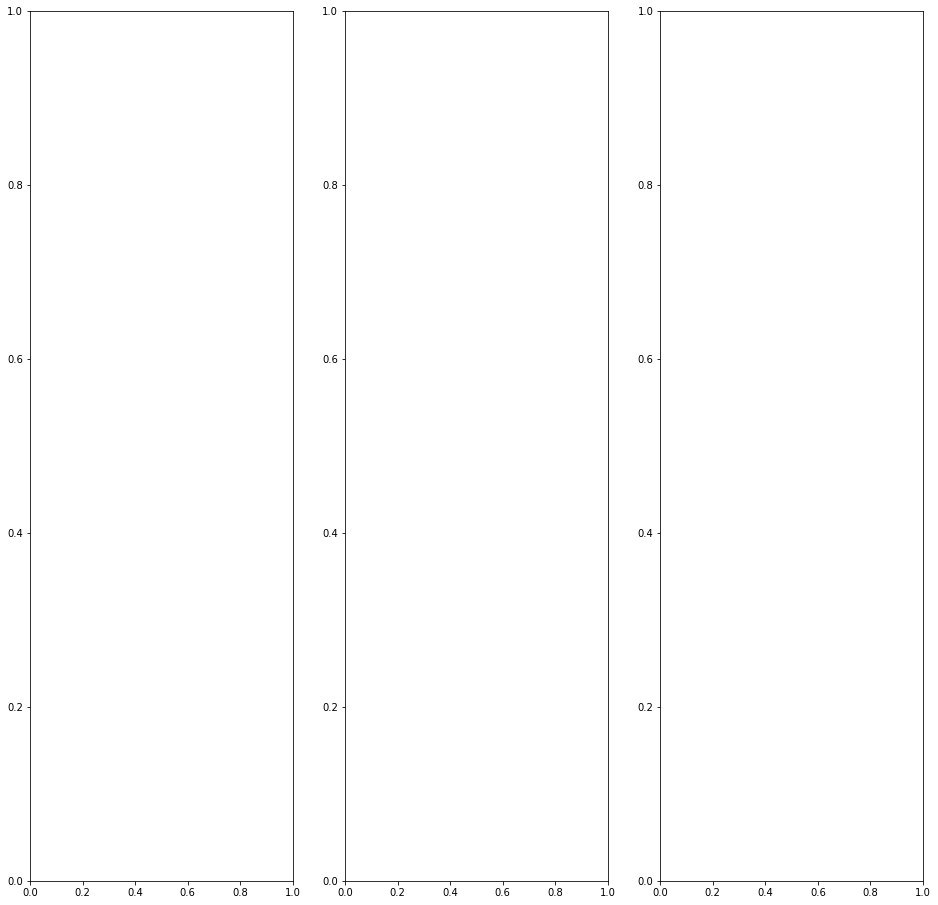

In [51]:
%matplotlib inline

import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

from PIL import Image

# Cycle over test images

test_img_dir = os.path.join(test_dir, 'images', 'img')
test_mask_dir = os.path.join(test_dir, 'masks', 'img')

img_filenames = next(os.walk(test_img_dir))[2]

# plt.show()

# Assign a color to each class
colors_dict = {}
colors_dict[0] = [255, 255, 255]   # foreground
colors_dict[1] = [0, 0, 0]   # background
colors_dict[2] = [0, 255, 0]   # contours


for img_filename in img_filenames: 
    fig, ax = plt.subplots(1, 3, figsize=(16,16))
    # mask_filename = img_filename[:-4] + '.png'
    
    img = Image.open(os.path.join(test_img_dir, img_filename))
    # img = img.resize((128, 128))
    mask = Image.open(os.path.join(test_mask_dir, img_filename))
    # mask = mask.resize((128, 128))
    
    img_arr = np.expand_dims(np.array(img), 0)
    
    # out_softmax = model.predict(x=img_arr)
    out_sigmoid = model.predict(x=img_arr)
    
    # Get predicted class as the index corresponding to the maximum value in the vector probability
    # predicted_class = tf.argmax(out_softmax, -1)
    predicted_class = tf.cast(out_sigmoid > 0.5, tf.float32)
    predicted_class = predicted_class[0]
    
    # target_img = np.expand_dims(np.array(mask), 0)
    # target = np.expand_dims(np.array(mask), 0)
    
    target = np.array(mask) / 255
    target -= 1    ## to get classes 0,1,2 instead of 1,2,3
    
    print(target.shape)
    
    # Assign colors (just for visualization)
    target_img = np.zeros([target.shape[0], target.shape[1], 3])
    prediction_img = np.zeros([target.shape[0], target.shape[1], 3])
    
    target_img[np.where(target == 0)] = colors_dict[0]
    target_img[np.where(target == 1)] = colors_dict[1]
    target_img[np.where(target == 2)] = colors_dict[2]
    
    prediction_img[np.where(predicted_class == 0)] = colors_dict[0]
    prediction_img[np.where(predicted_class == 1)] = colors_dict[1]
    prediction_img[np.where(predicted_class == 2)] = colors_dict[2]
    
    ax[0].imshow(np.uint8(img_arr[0, ...]))
    ax[1].imshow(np.uint8(target_img))
    ax[2].imshow(np.uint8(prediction_img))
    
    
    fig.canvas.draw()
    plt.show()
    
    time.sleep(1)